# Setup
This section imports analysis tools and loads and cleans the data.
The analysis begins in propper at **Basic Effects**.

In [26]:
%matplotlib inline
%load_ext rpy2.ipython
from utils import *

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [27]:
data = get_data()
pdf = data['participants']
df = data['graph']
pdf = pdf.loc[pdf.completed].copy()
df = df.set_index('pid').loc[pdf.index].reset_index()

df['pr_dist'] = df.pr_freq.apply(lambda x: 6. if x == 0 else x)
df.pr_freq = df.pr_freq.apply({0.0: 'none', 1.0: '1', 2.0: '2', 3.0: '3'}.get)
full = '6'
pr_freqs = 'none 3 2 1'.split()

figures = Figures('paper/figs/')
variables = Variables('paper/')
plot = figures.plot

df['max_return'] = df.returns.apply(lambda k: k[full])
df['score_ratio'] = df.score / df.max_return
df['trial_time'] = (df.action_times.apply(max) / 1000)
df['log_time'] = np.log(df.trial_time)

pdf['total_time'] = df.groupby('pid').time_elapsed.apply(max) / 60000
pdf['total_score'] = df.groupby('pid').score.sum()
pdf['score_ratio'] = df.groupby('pid').score_ratio.mean()

# Throw out trial times that are more than 2 sds above mean.
# These were likely due to the participant taking
# a break in the middle of a trial.
too_long = (df.trial_time > df.trial_time.mean() + 2 * df.trial_time.std())
df.trial_time.loc[too_long] = None
df['score_rate'] = df.score / df.trial_time

# Make sure counterbalance conditions are balanced
# by dropping extra participants
extra = pdf.counter_i.value_counts() - min(pdf.counter_i.value_counts())
df = df.set_index('pid')
for ci, n in extra.items():
    if n:
        drop = pdf[pdf.counter_i == ci].sample(n).index
        df.drop(n, inplace=True)
        pdf.drop(n, inplace=True)
df = df.reset_index()
variables.write('N_PARTICIPANT', len(pdf))

rcols = ('pid env pr_freq score stars score_rate pr_dist '
         'score_ratio trial_time trial_index').split()
rdf = df[rcols]

N_PARTICIPANT = 88


/usr/local/lib/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
%%R -i rdf
library(lme4)
library(car)
library(lsmeans)
df = rdf
df$env = factor(df$env)
df$pid = factor(df$pid)

In [29]:
# Renaming labels on figures.
def relabel(lab):
    titles = {
        'pr_freq': 'Pseudo-reward distance',
        'trial_time': 'Trial time (s)',
        'score_rate': 'Score per second',
        'score': 'Score',
        'score_ratio': 'Percentage of maximum score'
    }
    return titles.get(lab, lab)

def fix_labels(g):
    g.set_titles(col_template='{col_name}')
    for ax in g.axes.flat:
        ax.set_title(relabel(ax.get_title()))
#         ax.set_ylabel(relabel(ax.get_ylabel()))
        ax.set_xlabel(relabel(ax.get_xlabel()))

# Basic effects

paper/figs/basic.eps


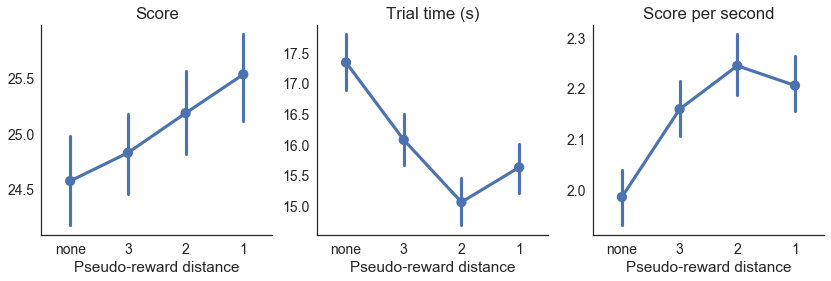

In [30]:
@plot()
def plot_basic():
    dd = pd.melt(df, id_vars=['pr_freq'],
                 value_vars=['score_rate', 'trial_time', 'score'])
    g = sns.factorplot('pr_freq', 'value', col='variable', data=dd,
                      sharey=False, order=pr_freqs,
                      col_order=['score', 'trial_time', 'score_rate'],
                      # color=(0.35, )*3, 
                       ci=68)
    fix_labels(g)
    g.axes[0, 0].set_ylabel('')

## PR frequency  →  score rate
Do PRs help participants score higher in smaller amounts of time?
We define the _score rate_ of a trial to be the average score per second.
We expected score rate to decrease monotonically with distance. 
Although, as seen above, this does not quite hold. The plot below
shows that score rates are approximately normally distributed for
all PR frequencies.

/usr/local/lib/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


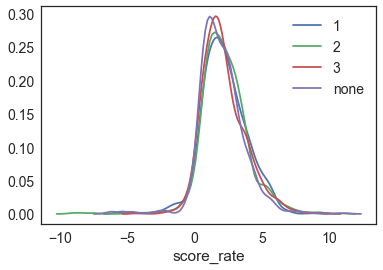

In [31]:
for prf, dd in df.groupby('pr_freq'):
    sns.distplot(dd.score_rate, label=prf, hist=False)
plt.legend()

In [32]:
%%R -o aov -o coef
full = lmer(score_rate ~ pr_dist + (1|pid), data=df)
null = update(full, . ~ . - pr_dist)
aov = anova(null, full)
print(aov)
coef = summary(full)$coefficients
print(coef)

/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: refitting model(s) with ML (instead of REML)

  warnings.warn(x, RRuntimeWarning)


Data: df
Models:
null: score_rate ~ (1 | pid)
full: score_rate ~ pr_dist + (1 | pid)
     Df   AIC   BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
null  3 12986 13005 -6490.0    12980                             
full  4 12976 13000 -6483.7    12968 12.624      1  0.0003807 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
               Estimate Std. Error   t value
(Intercept)  2.28580611 0.08761438 26.089395
pr_dist     -0.04876496 0.01371464 -3.555687


In [33]:
beta = coef[1,0]
baseline = df.query('pr_dist == 1').score_rate.mean()
variables.write('BETA_RATE', round(beta, 3))
variables.write('WORSEN_RATE',-1 * round(beta / baseline, 4) * 100)
aov_tbl = get_rtable(aov, p_col='pr_chisq')
variables.save_analysis(aov_tbl, Tex.chi2, 'AOV_RATE', display_tex=True)

BETA_RATE = -0.049
WORSEN_RATE = 2.21
AOV_RATE_NULL = $\chi^2(3)=nan,\ nan$


<IPython.core.display.Latex object>

AOV_RATE_FULL = $\chi^2(4)=12.62,\ p\,<\,0.001$


<IPython.core.display.Latex object>

## 3-step vs None

The difference between the least frequent PR and no PR at all is especially interesting.
We analyze this difference here.

In [34]:
%%R -o aov -o coef
sdf = subset(df, pr_dist >= 3)
sdf$pr = as.factor(sdf$pr_dist == 3)

full = lmer(score_rate ~ pr + (1|pid), data=sdf)
null = update(full, . ~ . - pr)
aov = anova(null, full)
print(aov)
coef = summary(full)$coefficients
print(coef)

/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: refitting model(s) with ML (instead of REML)

  warnings.warn(x, RRuntimeWarning)


Data: sdf
Models:
null: score_rate ~ (1 | pid)
full: score_rate ~ pr + (1 | pid)
     Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)  
null  3 6457.5 6473.9 -3225.8   6451.5                           
full  4 6453.9 6475.7 -3222.9   6445.9 5.6149      1    0.01781 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
             Estimate Std. Error   t value
(Intercept) 1.9809963 0.08397466 23.590406
prTRUE      0.1688374 0.07122278  2.370554


In [35]:
beta = coef[1,0]
baseline = df.query('pr_dist == 6').score_rate.mean()
variables.write('BETA_THREE', round(beta, 3))
variables.write('IMPROVEMENT_THREE', round(beta / baseline, 4) * 100)

aov_tbl = get_rtable(aov, p_col='pr_chisq')
variables.save_analysis(aov_tbl, Tex.chi2, 'AOV_THREE', display_tex=True)

BETA_THREE = 0.169
IMPROVEMENT_THREE = 8.51
AOV_THREE_NULL = $\chi^2(3)=nan,\ nan$


<IPython.core.display.Latex object>

AOV_THREE_FULL = $\chi^2(4)=5.61,\ p\,<\,0.05$


<IPython.core.display.Latex object>

# Planning time per move

The amount of time a participant waits before taking each action is indicative
of time spent planning. As expected, people take the longest time to make
their first move. We also see a subtler effect of the pseudo rewards. People
plan longer after reaching a PR state, indicating they have completed one
plan and are constructing a new one.

In [36]:
ats = (
    df
    .action_times
    .apply(
        lambda x: np.diff(np.insert(x, 0, 0))
    )
)

all_rt = np.stack(df.rt).ravel()
n_step = len(df.rt[0])
mdf = pd.DataFrame({
    'rt': all_rt,
    'step': np.arange(len(all_rt)) % n_step,
    'env': df.env.repeat(n_step),
    'pid': df.pid.repeat(n_step),
    'pr_dist': df.pr_freq.repeat(n_step),
    'trial_index': df.trial_index.repeat(n_step),
})
int_dist = mdf['pr_dist'].apply(lambda x: 0 if x is 'none' else int(x))
mdf['pr'] = mdf.step & (mdf.step % int_dist  == 0)
mdf.step += 1 # start at 1 for plotting 

paper/figs/plan_time.eps


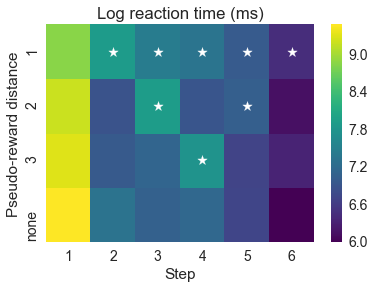

In [37]:
@plot()
def plot_plan_time():
    tbl = (
        mdf
        # .query('step > 0')
        .pivot_table(index='pr_dist', columns='step', values='rt')
        .applymap(np.log)
    )
    sns.heatmap(tbl, cmap='viridis')

    freqs = map(int, pr_freqs[1:])
    for pr in freqs:
        stars = np.array([[m-0.5, len(pr_freqs) - pr + 0.5] 
                          for m in range(2, 1+n_step) if pr == 1 or m % pr == 1])
        plt.scatter(*stars.T, c='w', marker='*', s=100)

    plt.title('Log reaction time (ms)')
    plt.xlabel('Step')
    plt.ylabel('Pseudo-reward distance')

In [38]:
# leave first step out of analysis
mdf2 = mdf.query('step > 1').copy()

## Permutation test

In [39]:
%%R -i mdf2
df = mdf2
df$pr = as.factor(df$pr)
require(coin)
oneway_test(rt~pr, data=df,
  distribution=approximate(B=10000))


	Approximative Two-Sample Fisher-Pitman Permutation Test

data:  rt by pr (FALSE, TRUE)
Z = -10.515, p-value < 2.2e-16
alternative hypothesis: true mu is not equal to 0

